In [242]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [243]:
'''
UTILIDADES
'''

from sklearn import datasets
import matplotlib.pyplot as plt

def generate_data(data_type, noise=0.2):
    """
    Generate a binary dataset with distribution data_type

    Arguments:
    data_type -- distribution of dataset {moons,circles,blobs}

    Returns:
    X -- features
    Y -- labels
    """ 
    np.random.seed(0)
    if data_type == 'moons':
        X, Y = datasets.make_moons(200, noise=noise)
    elif data_type == 'circles':
        X, Y = sklearn.datasets.make_circles(200, noise=noise)
    elif data_type == 'blobs':
        X, Y = sklearn.datasets.make_blobs(centers=2, cluster_std=noise)
    return X, Y

def linear_activation(W, b, X):
    z = np.dot(W,X) + b
    
    return z

def sigmoid(z):
    return 1. / (1. + np.exp(-z))

def predict_multilayer(parameters,X):
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    Z1 = linear_activation(W1,b1,X)
    A1 = sigmoid(Z1)
    
    Z2 = linear_activation(W2,b2,A1)
    A2 = sigmoid(Z2)

    return np.round(A2)

def visualize_lr(parameters, X, Y):
    X = X.T
    
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    #Z = pred_func(W,b,np.c_[xx.ravel(), yy.ravel()])
    Z = predict_multilayer(parameters, np.c_[xx.ravel(), yy.ravel()].T)
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.figure(figsize=(7,5))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    
    color= ['blue' if y == 1 else 'red' for y in np.squeeze(Y)]
    plt.scatter(X[:,0], X[:,1], color=color)
    
    plt.show()

<hr>
## 1. Cargue del dataset

In [261]:
'''
Dataset de ejemplo para clasificacion binaria
'''
import sklearn
from sklearn.datasets import make_blobs, make_moons

dataset = generate_data('circles')
x = dataset[0]
y = dataset[1]

nx,m = x.T.shape

colors = ['red' if label == 1 else 'blue' for label in y]

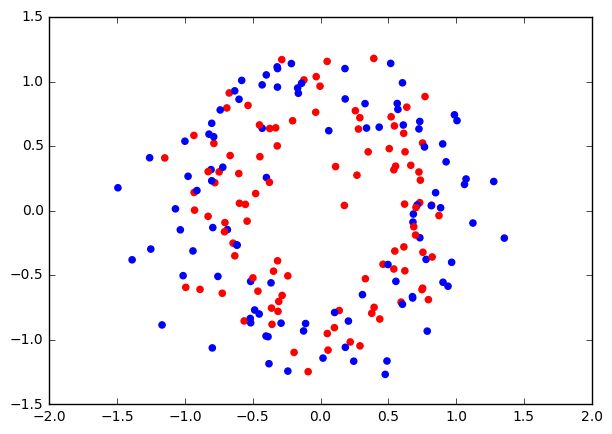

In [262]:
plt.figure(figsize=(7,5))
plt.scatter(x[:,0], x[:,1], color=colors)

plt.show()

#x = x.T

<hr>
## 2. MLP: Implementacion explicita

In [326]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [327]:
def d_sigmoid(z):
    return tf.nn.sigmoid(z)*(1.-tf.nn.sigmoid(z))

def loss(y, a):
    return -(y * tf.log(a) + (1.-y) * tf.log(1.-a))

In [328]:
reset_graph()

learning_rate = 0.01

#dataset en forma de tensores
X = tf.constant(x.T, dtype=tf.float32, name="X")
Y = tf.constant(y, dtype=tf.float32, name="Y")

nx = x.shape[1] #numero de caracteristicas de la capa de 
n_hidden_layer = 10

'''
parametros de la red
'''

W1 = tf.Variable(tf.random_uniform([n_hidden_layer, nx]), name="W1", dtype=tf.float32)
b1 = tf.Variable(tf.random_uniform([n_hidden_layer,1]), name="b1", dtype=tf.float32)

W2 = tf.Variable(tf.random_uniform([1, n_hidden_layer]), name="W2", dtype=tf.float32)
b2 = tf.Variable(tf.random_uniform([1, 1]), name="b", dtype=tf.float32)

'''
grafo de computo
'''

'''
forward propagation
'''
Z1 = tf.matmul(W1, X) + b1
A1 = tf.nn.sigmoid(Z1)

Z2 = tf.matmul(W2, A1) + b2
A2 = tf.nn.sigmoid(Z2)

'''
back propagation
'''
dZ2 = A2 - Y
dW2 = tf.matmul(dZ2, tf.transpose(A1))
db2 = tf.reduce_mean(tf.reduce_sum(dZ2))

dZ1 = tf.multiply(tf.matmul(tf.transpose(W2), dZ2), d_sigmoid(Z1))
dW1 = tf.matmul(dZ1, tf.transpose(X))
db1 = tf.reduce_mean(tf.reduce_sum(dZ1))

'''
update
'''
training_W1 = tf.assign(W1, W1 - learning_rate*dW1)
training_b1 = tf.assign(b1, b1 - learning_rate*db1)
training_W2 = tf.assign(W2, W2 - learning_rate*dW2)
training_b2 = tf.assign(b2, b2 - learning_rate*db2)
'''
cost
'''
J = tf.reduce_mean(loss(y,A2))

<hr>
## 3. Entrenamiento del modelo

In [329]:
init = tf.global_variables_initializer()

n_epochs = 10000

with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(n_epochs):
        if(epoch % 1000 == 0):
            print ("Epoca ", epoch, "Error: ", J.eval())
        
        sess.run([training_W1, training_b1, training_W2, training_b2])
        
        best_W1 = W1.eval()
        best_b1 = b1.eval()
        best_W2 = W2.eval()
        best_b2 = b2.eval()

    print best_W1, best_b1
    print best_W2, best_b2
        

('Epoca ', 0, 'Error: ', 1.9249623)
('Epoca ', 1000, 'Error: ', 0.66473937)
('Epoca ', 2000, 'Error: ', 0.65005785)
('Epoca ', 3000, 'Error: ', 0.60018343)
('Epoca ', 4000, 'Error: ', 0.59657472)
('Epoca ', 5000, 'Error: ', 0.59516245)
('Epoca ', 6000, 'Error: ', 0.59416288)
('Epoca ', 7000, 'Error: ', 0.59349257)
('Epoca ', 8000, 'Error: ', 0.59305674)
('Epoca ', 9000, 'Error: ', 0.5927875)
[[ 0.53896183  0.25049531]
 [ 0.54472023  0.26145589]
 [ 0.87460071 -1.05161119]
 [ 0.61996382 -0.27788007]
 [-2.89008403 -3.89248562]
 [-1.89601254  4.08180857]
 [ 0.618752   -0.19536996]
 [ 2.97377706 -0.52009368]
 [ 1.14584589 -1.47347081]
 [ 0.60944194 -0.24299937]] [[-3.10630131]
 [-3.27787828]
 [-2.44085693]
 [-2.71123123]
 [-2.77034378]
 [-2.41679716]
 [-2.67453671]
 [-2.56024599]
 [-2.39433479]
 [-2.78119564]]
[[  0.90003842   1.03633392   2.46909261   1.755705    -5.80425596
   -4.98305035   1.49474525 -11.88274956   2.68616295   1.75171924]] [[ 3.89383483]]


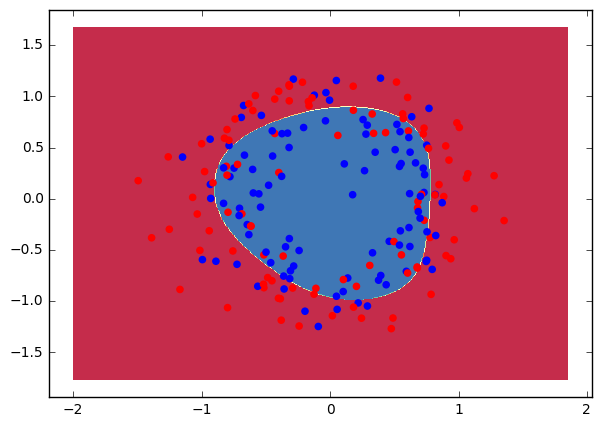

In [330]:
parameters = {'W1':best_W1, 'b1':best_b1, 'W2':best_W2, 'b2':best_b2}
visualize_lr(parameters, x.T, y)

<hr>
## 4. Implementacion utilizando utilidades de TensorFlow

In [335]:
reset_graph()

learning_rate = 0.6

#dataset en forma de tensores
X = tf.constant(x.T, dtype=tf.float32, name="X")
Y = tf.constant(y, dtype=tf.float32, name="Y")

nx = x.shape[1] #numero de caracteristicas de la capa de 
n_hidden_layer = 10

'''
parametros de la red
'''

W1 = tf.Variable(tf.random_uniform([n_hidden_layer, nx]), name="W1", dtype=tf.float32)
b1 = tf.Variable(tf.random_uniform([n_hidden_layer,1]), name="b1", dtype=tf.float32)

W2 = tf.Variable(tf.random_uniform([1, n_hidden_layer]), name="W2", dtype=tf.float32)
b2 = tf.Variable(tf.random_uniform([1, 1]), name="b", dtype=tf.float32)

'''
grafo de computo
'''

'''
forward propagation
'''
Z1 = tf.matmul(W1, X) + b1
A1 = tf.nn.sigmoid(Z1)

Z2 = tf.matmul(W2, A1) + b2
A2 = tf.nn.sigmoid(Z2)

'''
error
'''
loss = -(y * tf.log(A2) + (1.-y) * tf.log(1.-A2))
J = tf.reduce_mean(loss)

'''
optimizacion
'''
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(J)

In [336]:
init = tf.global_variables_initializer()

n_epochs = 10000

with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(n_epochs):
        if(epoch % 1000 == 0):
            print ("Epoca ", epoch, "Error: ", J.eval())
        
        sess.run(optimizer)
        
        best_W1 = W1.eval()
        best_b1 = b1.eval()
        best_W2 = W2.eval()
        best_b2 = b2.eval()

    print best_W1, best_b1
    print best_W2, best_b2

('Epoca ', 0, 'Error: ', 1.9249623)
('Epoca ', 1000, 'Error: ', 0.68944991)
('Epoca ', 2000, 'Error: ', 0.65400714)
('Epoca ', 3000, 'Error: ', 0.60376328)
('Epoca ', 4000, 'Error: ', 0.59393942)
('Epoca ', 5000, 'Error: ', 0.58891863)
('Epoca ', 6000, 'Error: ', 0.58656043)
('Epoca ', 7000, 'Error: ', 0.58524287)
('Epoca ', 8000, 'Error: ', 0.58426356)
('Epoca ', 9000, 'Error: ', 0.58344388)
[[ 0.30087015 -0.1707627 ]
 [ 0.54277867  0.49492326]
 [ 4.42643929 -2.36760664]
 [ 0.41221187 -0.56187415]
 [ 1.47854161  4.89895201]
 [ 1.70191216  2.21439743]
 [ 0.80720532 -0.0552364 ]
 [ 5.46505547 -0.83825648]
 [ 0.30684799 -0.69651598]
 [ 0.28945121 -0.56650615]] [[ 0.16032752]
 [-0.33309224]
 [ 4.05770206]
 [ 0.53133351]
 [-3.25149012]
 [ 1.8866632 ]
 [ 0.78317666]
 [-5.28450203]
 [ 0.94156659]
 [ 0.57049596]]
[[-0.95420516 -0.87853825  4.07683945 -1.36045575 -3.86255646  5.02821493
  -0.35465762 -7.16097164 -1.57868361 -1.16812897]] [[-1.89359641]]


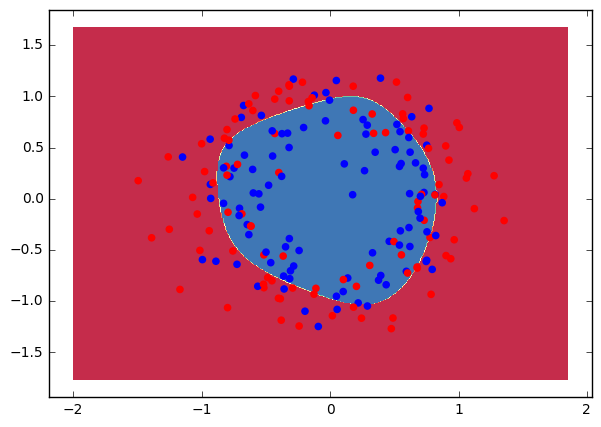

In [338]:
parameters = {'W1':best_W1, 'b1':best_b1, 'W2':best_W2, 'b2':best_b2}
visualize_lr(parameters, x.T, y)

<hr>
## Trabajemos:
Agregue una nueva capa al perceptron multicapa.